In [1]:
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, CRD, DCD2, PDB_small
from MDAnalysis.analysis import distances,diffusionmap, align, rms,contacts,dihedrals, encore
from MDAnalysis.analysis.rms import RMSF
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from mpl_toolkits.axisartist.parasite_axes import SubplotHost
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
from itertools import product
import timeit
import time
import math
import os.path
import seaborn as sns
import pandas as pd
import csv
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
import scipy.signal as sig
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import scipy.integrate as integrate
import scipy.special as special

In [4]:
path='/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/'
u_wta=mda.Universe(path+'wt_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'wt_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_wtb=mda.Universe(path+'wt_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'wt_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_dma=mda.Universe(path+'dm_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'dm_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_dmb=mda.Universe(path+'dm_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'dm_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_delP168a=mda.Universe(path+'delP168_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'delP168_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_delP168b=mda.Universe(path+'delP168_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'delP168_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_a173va=mda.Universe(path+'a173v_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'a173v_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_a173vb=mda.Universe(path+'a173v_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'a173v_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

In [3]:
data_dir='/net/gpfs-amarolab/fiona/sars-cov-2/protease/'
wta_dat=np.load(data_dir+'wta_s2_pocket.npy')
wtb_dat=np.load(data_dir+'wtb_s2_pocket.npy')
dma_dat=np.load(data_dir+'dma_s2_pocket.npy')
dmb_dat=np.load(data_dir+'dmb_s2_pocket.npy')
delP168a_dat=np.load(data_dir+'delP168a_s2_pocket.npy')
delP168b_dat=np.load(data_dir+'delP168b_s2_pocket.npy')
a173va_dat=np.load(data_dir+'a173va_s2_pocket.npy')
a173vb_dat=np.load(data_dir+'a173vb_s2_pocket.npy')

In [14]:
wta_hbond=np.load(data_dir+'wt_chainA_q189_m49_hbond.npy')
wtb_hbond=np.load(data_dir+'wt_chainb_q189_m49_hbond.npy')
dma_hbond=np.load(data_dir+'dm_chainA_q189_m49_hbond.npy')
dmb_hbond=np.load(data_dir+'dm_chainb_q189_m49_hbond.npy')
delP168a_hbond=np.load(data_dir+'delP168_chainA_q189_m49_hbond.npy')
delP168b_hbond=np.load(data_dir+'delP168_chainb_q189_m49_hbond.npy')
a173va_hbond=np.load(data_dir+'a173v_chainA_q189_m49_hbond.npy')
a173vb_hbond=np.load(data_dir+'a173v_chainb_q189_m49_hbond.npy')

In [24]:
def plot_scatter(wt_dat,wt_hbond,dm_dat,dm_hbond,delP168_dat,delP168_hbond,a173v_dat,a173v_hbond,title):
    params = {
        #'font.family': 'sans-serif',
        #'font.sans-serif': 'Arial',
         'legend.fontsize': '36',
         #'figure.figsize': (24,12),
         'axes.labelsize': '40',
         'axes.titlesize': '40',
         'xtick.labelsize': '24',
         'ytick.labelsize': '24'
         #'xtick.size': '30'
         #'ytick.size': '30'
    }
    
    pylab.rcParams.update(params)
    
    left,width=0.1,0.65
    bottom,height=0.1,0.65
    spacing=0.005
    
    rect_scatter=[left,bottom,width,height]
    rect_histx=[left,bottom+height+spacing,width,0.2]
    rect_histy=[left+width+spacing,bottom,0.2,width]
    
    fig=plt.figure(figsize=(12,12))
    
    ax=fig.add_axes(rect_scatter)
    ax_histx=fig.add_axes(rect_histx,sharex=ax)
    ax_histy=fig.add_axes(rect_histy,sharey=ax)
    
    ax_histx.tick_params(axis="x",labelbottom=False)
    ax_histy.tick_params(axis="y",labelbottom=False)
    
    ## plot a_XXX's together
    ax.scatter(wt_dat,wt_hbond,color='black',alpha=0.8)
    ax.scatter(dm_dat,dm_hbond,color='blue',alpha=0.8)
    ax.scatter(delP168_dat,delP168_hbond,color='red',alpha=0.8)
    ax.scatter(a173v_dat,a173v_hbond,color='green',alpha=0.8)
    
    bins_x=np.arange(0,30,0.5).tolist()
    bins_y=np.arange(2,20,0.5).tolist()
    ax_histx.hist(wt_dat,bins_x,color='k',alpha=0.8)
    ax_histy.hist(wt_hbond,bins_y,orientation='horizontal',color='k',alpha=0.8)
    ax_histx.hist(dm_dat,bins_x,color='b',alpha=0.8)
    ax_histy.hist(dm_hbond,bins_y,orientation='horizontal',color='b',alpha=0.8)
    ax_histx.hist(delP168_dat,bins_x,color='r',alpha=0.8)
    ax_histy.hist(delP168_hbond,bins_y,orientation='horizontal',color='r',alpha=0.8)
    ax_histx.hist(a173v_dat,bins_x,color='g',alpha=0.8)
    ax_histy.hist(a173v_hbond,bins_y,orientation='horizontal',color='g',alpha=0.8)
    
    ax.set_ylabel("HBond Dist M49 to Q189 ($\AA{}$)")
    ax.set_xlabel("X173 to F185 Dist ($\AA{}$)")
    
    plt.savefig('hbond_dist_scatter.png'.format(title),bbox_inches='tight',dpi=300)

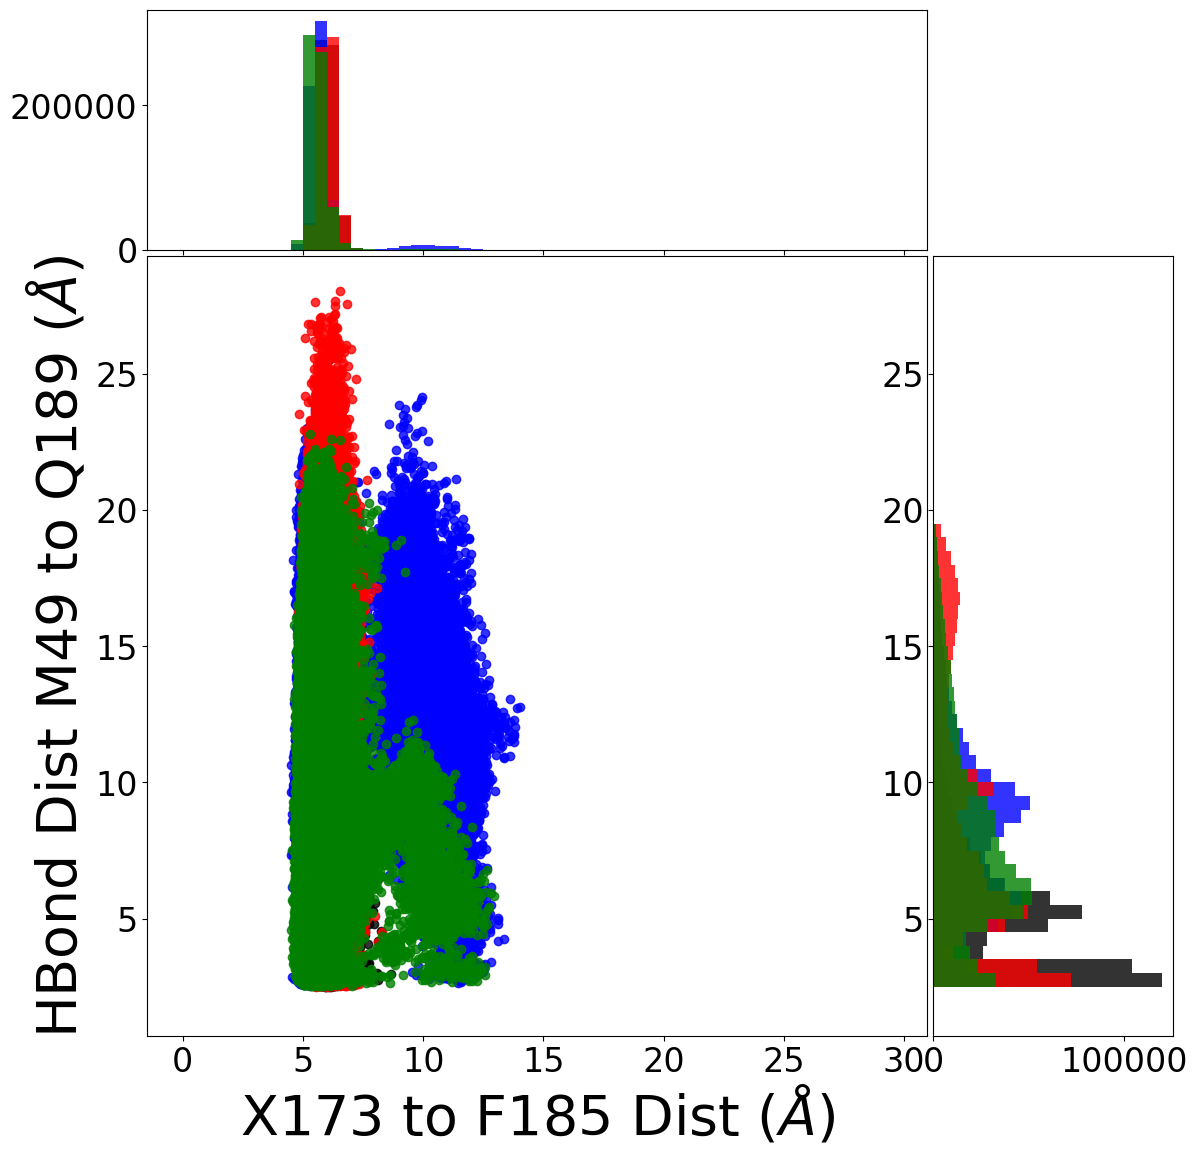

In [25]:
plot_scatter(wt_dat_all[:,0],wt_hbond_all[:,0],dm_dat_all[:,0],dm_hbond_all[:,0],delP168_dat_all[:,0],delP168_hbond_all[:,0],a173v_dat_all[:,0],a173v_hbond_all[:,0],"test")

In [16]:
wt_dat_all=np.concatenate((wta_dat,wtb_dat))
dm_dat_all=np.concatenate((dma_dat,dmb_dat))
delP168_dat_all=np.concatenate((delP168a_dat,delP168b_dat))
a173v_dat_all=np.concatenate((a173va_dat,a173vb_dat))

wt_hbond_all=np.concatenate((wta_hbond[:,[0,1]],wtb_hbond[:,[0,1]]))
dm_hbond_all=np.concatenate((dma_hbond[:,[0,1]],dmb_hbond[:,[0,1]]))
delP168_hbond_all=np.concatenate((delP168a_hbond[:,[0,1]],delP168b_hbond[:,[0,1]]))
a173v_hbond_all=np.concatenate((a173va_hbond[:,[0,1]],a173vb_hbond[:,[0,1]]))

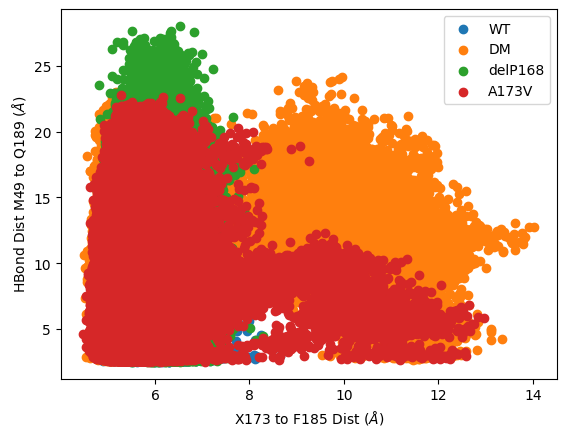

In [19]:
plt.scatter(wt_dat_all[:,0],wt_hbond_all[:,0],label="WT")
plt.scatter(dm_dat_all[:,0],dm_hbond_all[:,0],label="DM")
plt.scatter(delP168_dat_all[:,0],delP168_hbond_all[:,0],label="delP168")
plt.scatter(a173v_dat_all[:,0],a173v_hbond_all[:,0],label="A173V")
plt.xlabel("X173 to F185 Dist ($\AA{}$)")
plt.ylabel("HBond Dist M49 to Q189 ($\AA{}$)")
plt.legend()

In [7]:
def calc_s2_contacts(u,title):
    ## residues of interest: 346 --> 331 --> 310
    
    def calc_area(a,b,c):
        s=(a+b+c)/2
        area=(s*(s-a)*(s-b)*(s-c))**0.5
        return(area)
    
    results=[]
    for ts in u.trajectory:
        x173=u.select_atoms("resid 173").center_of_geometry()
        f185=u.select_atoms("resid 185").center_of_geometry()
        l167=u.select_atoms("resid 167").center_of_geometry()
        x173_f185=np.min(distances.distance_array(x173,f185))
        f185_l167=np.min(distances.distance_array(f185,l167))
        l167_x173=np.min(distances.distance_array(l167,x173))
        area=calc_area(x173_f185,f185_l167,l167_x173)
        results.append((x173_f185,f185_l167,l167_x173,area))

    results=np.array(results).reshape(len(results),4)
    with open('{}_s2_pocket.npy'.format(title),'wb') as f:
        np.save(f,results)
    print("Finished") 
    return(results)

In [13]:
wta_dat=calc_s2_contacts(u_wta,"wta")
wtb_dat=calc_s2_contacts(u_wtb,"wtb")

In [14]:
dma_dat=calc_s2_contacts(u_dma,"dma")
dmb_dat=calc_s2_contacts(u_dmb,"dmb")

In [15]:
delP168a_dat=calc_s2_contacts(u_delP168a,"delP168a")
delP168b_dat=calc_s2_contacts(u_delP168b,"delP168b")

In [16]:
a173va_dat=calc_s2_contacts(u_a173va,"a173va")
a173vb_dat=calc_s2_contacts(u_a173vb,"a173vb")

(array([1.04800e+04, 1.59474e+05, 1.26550e+05, 2.74140e+04, 5.07100e+03,
        7.57000e+02, 1.74000e+02, 7.10000e+01, 6.00000e+00, 3.00000e+00]),
 array([4.53521852, 5.00708579, 5.47895306, 5.95082033, 6.42268759,
        6.89455486, 7.36642213, 7.8382894 , 8.31015666, 8.78202393,
        9.2538912 ]),
 <BarContainer object of 10 artists>)

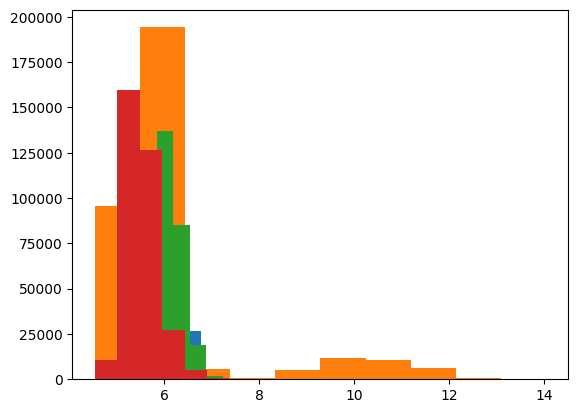

In [18]:
plt.hist(wta_dat[:,0])
plt.hist(dma_dat[:,0])
plt.hist(delP168a_dat[:,0])
plt.hist(a173va_dat[:,0])

(array([1.05100e+03, 2.14300e+04, 1.03808e+05, 1.31639e+05, 5.91640e+04,
        1.11130e+04, 1.17200e+03, 3.22000e+02, 2.45000e+02, 5.60000e+01]),
 array([ 5.38192785,  5.94285612,  6.5037844 ,  7.06471267,  7.62564094,
         8.18656921,  8.74749748,  9.30842575,  9.86935403, 10.4302823 ,
        10.99121057]),
 <BarContainer object of 10 artists>)

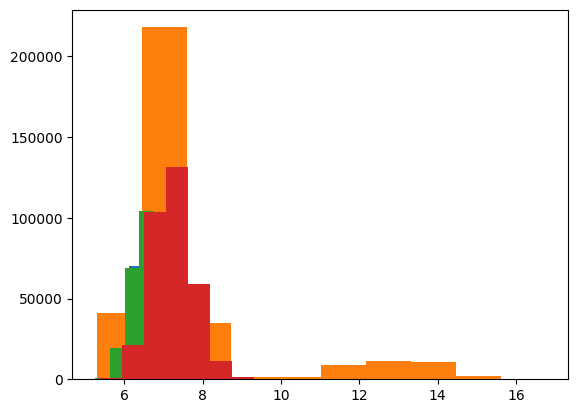

In [19]:
plt.hist(wta_dat[:,1])
plt.hist(dma_dat[:,1])
plt.hist(delP168a_dat[:,1])
plt.hist(a173va_dat[:,1])

(array([8.00800e+03, 1.00113e+05, 1.54409e+05, 5.84460e+04, 7.70600e+03,
        8.15000e+02, 2.03000e+02, 1.72000e+02, 1.05000e+02, 2.30000e+01]),
 array([4.7150269 , 5.13333004, 5.55163317, 5.9699363 , 6.38823944,
        6.80654257, 7.2248457 , 7.64314884, 8.06145197, 8.47975511,
        8.89805824]),
 <BarContainer object of 10 artists>)

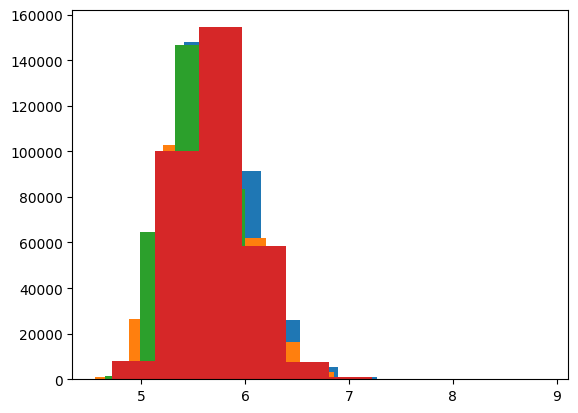

In [20]:
plt.hist(wta_dat[:,2])
plt.hist(dma_dat[:,2])
plt.hist(delP168a_dat[:,2])
plt.hist(a173va_dat[:,2])

(array([2.69000e+03, 6.38850e+04, 1.61009e+05, 8.05240e+04, 1.75340e+04,
        3.30400e+03, 7.77000e+02, 2.31000e+02, 3.60000e+01, 1.00000e+01]),
 array([11.39579699, 12.89437717, 14.39295735, 15.89153754, 17.39011772,
        18.8886979 , 20.38727809, 21.88585827, 23.38443845, 24.88301864,
        26.38159882]),
 <BarContainer object of 10 artists>)

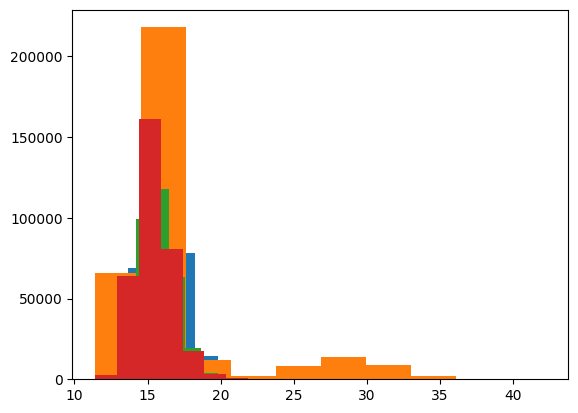

In [21]:
plt.hist(wta_dat[:,3])
plt.hist(dma_dat[:,3])
plt.hist(delP168a_dat[:,3])
plt.hist(a173va_dat[:,3])

In [32]:
def plot_distributions(wt,dm,delP168,a173v,title):
    params = {
        #'font.family': 'sans-serif',
        #'font.sans-serif': 'Arial',
         'legend.fontsize': '36',
         #'figure.figsize': (24,12),
         'axes.labelsize': '40',
         'axes.titlesize': '40',
         'xtick.labelsize': '24',
         'ytick.labelsize': '24'
         #'xtick.size': '30'
         #'ytick.size': '30'
    }
    
    pylab.rcParams.update(params)
    
    def calc_auc(function):
        auc0_percent=math.floor(integrate.quad(function,0,8)[0]*100)
        auc1_percent=math.floor(integrate.quad(function,8,20)[0]*100)
        return(auc0_percent,auc1_percent)
    
    collection=wt+dm+delP168+a173v
    start=np.min(collection)-1
    stop=np.max(collection)+1
    
    domain = np.linspace(start,stop,1000)
    dens_wt = gaussian_kde(wt)
    dens_wt.covariance_factor = lambda : 0.25
    dens_dm = gaussian_kde(dm)
    dens_dm.covariance_factor = lambda : 0.25
    dens_delP168 = gaussian_kde(delP168)
    dens_delP168.covariance_factor = lambda : 0.25
    dens_a173v = gaussian_kde(a173v)
    dens_a173v.covariance_factor = lambda : 0.25
    
    #fig = plt.figure(figsize=(12,8))
    fig, axs = plt.subplots(1,1, sharex=True, sharey=True, tight_layout=True, figsize=(10,10))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    wt_auc0,wt_auc1=calc_auc(dens_wt)
    dm_auc0,dm_auc1=calc_auc(dens_dm)
    delP168_auc0,delP168_auc1=calc_auc(dens_delP168)
    a173v_auc0,a173v_auc1=calc_auc(dens_a173v)
    
    ## plot a_XXX's together
    axs.axvline(x=8,color='lightgrey',linestyle='-')
    p1, = axs.plot(domain,dens_wt(domain),'black',alpha=0.8,linewidth=4,label='WT') ## column 2 = interface 1
    axs.fill_between(domain,dens_wt(domain),color='black',alpha=0.2)
    p2, = axs.plot(domain,dens_dm(domain),'blue',alpha=0.8,linewidth=4,label='DM') ## column 2 = interface 1
    axs.fill_between(domain,dens_dm(domain),color='blue',alpha=0.2)
    p3, = axs.plot(domain,dens_delP168(domain),'red',alpha=0.8,linewidth=4,label="$\Delta$P168") ## column 2 = interface 1
    axs.fill_between(domain,dens_delP168(domain),color='red',alpha=0.2)
    p4, = axs.plot(domain,dens_a173v(domain),'g',alpha=0.8,linewidth=4,label='A173V') ## column 2 = interface 1
    axs.fill_between(domain,dens_a173v(domain),color='g',alpha=0.2)
    
    axs.annotate("WT {}%".format(wt_auc0),(5,0.35),xycoords='data',fontsize=16)
    axs.annotate("DM {}%".format(dm_auc0),(5,0.34),xycoords='data',fontsize=16)
    axs.annotate("$\Delta$P168 {}%".format(delP168_auc0),(5,0.33),xycoords='data',fontsize=16)
    axs.annotate("A173V{}%".format(a173v_auc0),(5,0.32),xycoords='data',fontsize=16)
    axs.annotate("WT {}%".format(wt_auc1),(10,0.35),xycoords='data',fontsize=16)
    axs.annotate("DM {}%".format(dm_auc1),(10,0.34),xycoords='data',fontsize=16)
    axs.annotate("$\Delta$P168 {}%".format(delP168_auc1),(10,0.33),xycoords='data',fontsize=16)
    axs.annotate("A173V {}%".format(a173v_auc1),(10,0.32),xycoords='data',fontsize=16)
    
    #plt.title("Distribution of C145-S to H41-N Dist")
    plt.ylabel("Density",labelpad=40)
    plt.xlabel("X173 to F185 Distance ($\AA{}$)")
    
    plt.legend(fontsize=36)
    plt.legend(handles=[p1, p2, p3, p4],bbox_to_anchor=(0.85,-0.15),ncol=4,fontsize=16)
    fig.tight_layout()
    plt.savefig('{}_x173_f185_dist.png'.format(title),bbox_inches='tight',dpi=300)

In [33]:
wt_all=wta_dat[:,0].tolist()+wtb_dat[:,0].tolist()
dm_all=dma_dat[:,0].tolist()+dmb_dat[:,0].tolist()
delP168_all=delP168a_dat[:,0].tolist()+delP168b_dat[:,0].tolist()
a173v_all=a173va_dat[:,0].tolist()+a173vb_dat[:,0].tolist()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


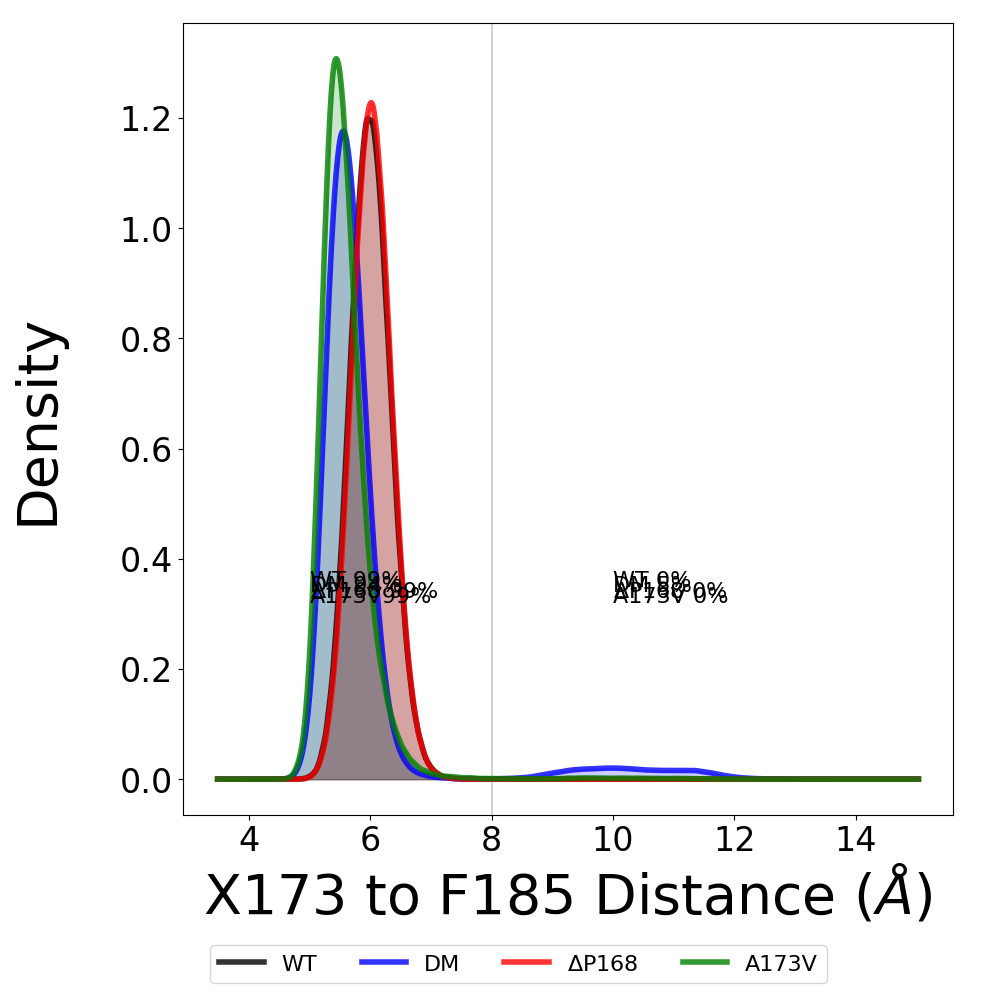

In [34]:
plot_distributions(wt_all,dm_all,delP168_all,a173v_all,"wt_dm_delP168_a173v")

In [31]:
wt_area_all=wta_dat[:,3].tolist()+wtb_dat[:,3].tolist()
dm_area_all=dma_dat[:,3].tolist()+dmb_dat[:,3].tolist()
delP168_area_all=delP168a_dat[:,3].tolist()+delP168b_dat[:,3].tolist()
a173v_area_all=a173va_dat[:,3].tolist()+a173vb_dat[:,3].tolist()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


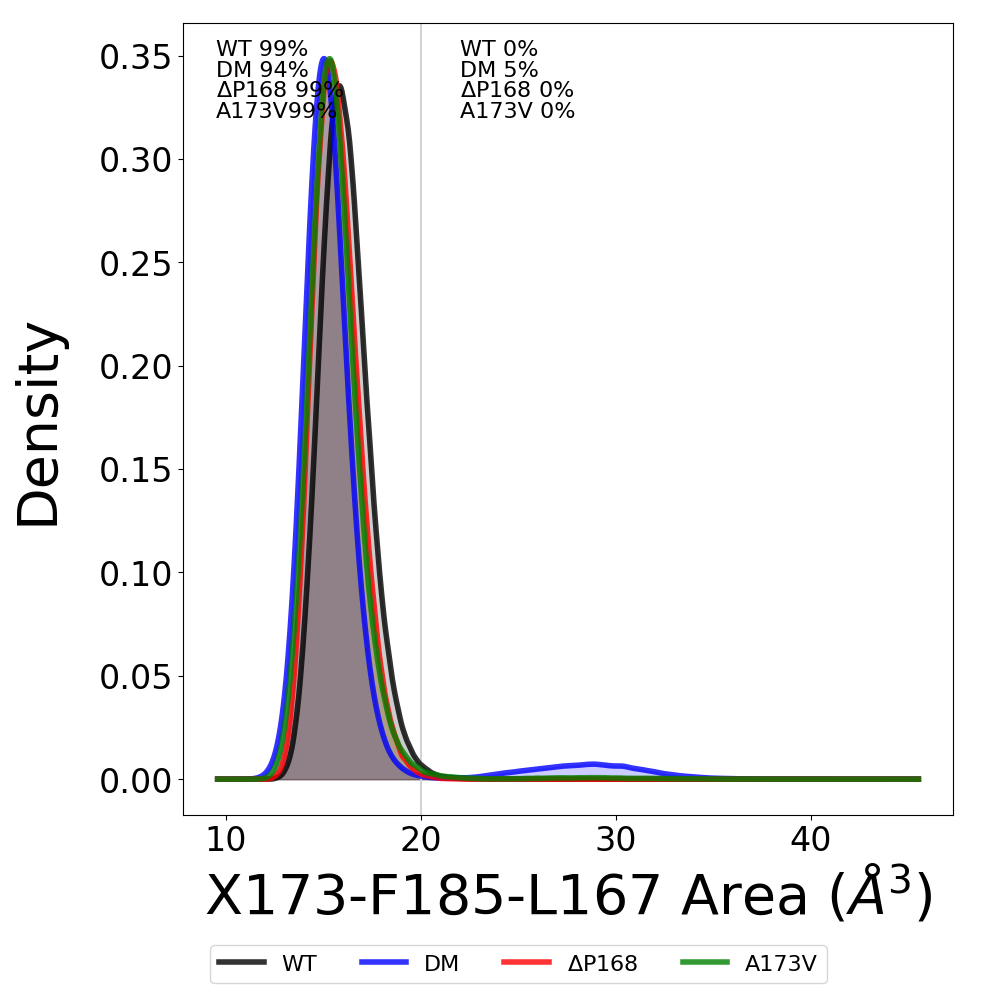

In [32]:
plot_area_distributions(wt_area_all,dm_area_all,delP168_area_all,a173v_area_all,"wt_dm_delP168_a173v")

In [30]:
def plot_area_distributions(wt,dm,delP168,a173v,title):
    params = {
        #'font.family': 'sans-serif',
        #'font.sans-serif': 'Arial',
         'legend.fontsize': '36',
         #'figure.figsize': (24,12),
         'axes.labelsize': '40',
         'axes.titlesize': '40',
         'xtick.labelsize': '24',
         'ytick.labelsize': '24'
         #'xtick.size': '30'
         #'ytick.size': '30'
    }
    
    pylab.rcParams.update(params)
    
    def calc_auc(function):
        auc0_percent=math.floor(integrate.quad(function,10,20)[0]*100)
        auc1_percent=math.floor(integrate.quad(function,20,40)[0]*100)
        return(auc0_percent,auc1_percent)
    
    collection=wt+dm+delP168+a173v
    start=np.min(collection)-1
    stop=np.max(collection)+1
    
    domain = np.linspace(start,stop,1000)
    dens_wt = gaussian_kde(wt)
    dens_wt.covariance_factor = lambda : 0.25
    dens_dm = gaussian_kde(dm)
    dens_dm.covariance_factor = lambda : 0.25
    dens_delP168 = gaussian_kde(delP168)
    dens_delP168.covariance_factor = lambda : 0.25
    dens_a173v = gaussian_kde(a173v)
    dens_a173v.covariance_factor = lambda : 0.25
    
    #fig = plt.figure(figsize=(12,8))
    fig, axs = plt.subplots(1,1, sharex=True, sharey=True, tight_layout=True, figsize=(10,10))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    wt_auc0,wt_auc1=calc_auc(dens_wt)
    dm_auc0,dm_auc1=calc_auc(dens_dm)
    delP168_auc0,delP168_auc1=calc_auc(dens_delP168)
    a173v_auc0,a173v_auc1=calc_auc(dens_a173v)
    
    ## plot a_XXX's together
    axs.axvline(x=20,color='lightgrey',linestyle='-')
    p1, = axs.plot(domain,dens_wt(domain),'black',alpha=0.8,linewidth=4,label='WT') ## column 2 = interface 1
    axs.fill_between(domain,dens_wt(domain),color='black',alpha=0.2)
    p2, = axs.plot(domain,dens_dm(domain),'blue',alpha=0.8,linewidth=4,label='DM') ## column 2 = interface 1
    axs.fill_between(domain,dens_dm(domain),color='blue',alpha=0.2)
    p3, = axs.plot(domain,dens_delP168(domain),'red',alpha=0.8,linewidth=4,label="$\Delta$P168") ## column 2 = interface 1
    axs.fill_between(domain,dens_delP168(domain),color='red',alpha=0.2)
    p4, = axs.plot(domain,dens_a173v(domain),'g',alpha=0.8,linewidth=4,label='A173V') ## column 2 = interface 1
    axs.fill_between(domain,dens_a173v(domain),color='g',alpha=0.2)
    
    axs.annotate("WT {}%".format(wt_auc0),(9.5,0.35),xycoords='data',fontsize=16)
    axs.annotate("DM {}%".format(dm_auc0),(9.5,0.34),xycoords='data',fontsize=16)
    axs.annotate("$\Delta$P168 {}%".format(delP168_auc0),(9.5,0.33),xycoords='data',fontsize=16)
    axs.annotate("A173V{}%".format(a173v_auc0),(9.5,0.32),xycoords='data',fontsize=16)
    axs.annotate("WT {}%".format(wt_auc1),(22,0.35),xycoords='data',fontsize=16)
    axs.annotate("DM {}%".format(dm_auc1),(22,0.34),xycoords='data',fontsize=16)
    axs.annotate("$\Delta$P168 {}%".format(delP168_auc1),(22,0.33),xycoords='data',fontsize=16)
    axs.annotate("A173V {}%".format(a173v_auc1),(22,0.32),xycoords='data',fontsize=16)
    
    #plt.title("Distribution of C145-S to H41-N Dist")
    plt.ylabel("Density",labelpad=40)
    plt.xlabel("X173-F185-L167 Area ($\AA{}^3$)")
    
    plt.legend(fontsize=36)
    plt.legend(handles=[p1, p2, p3, p4],bbox_to_anchor=(0.85,-0.15),ncol=4,fontsize=16)
    fig.tight_layout()
    plt.savefig('{}_x173_f185_l167_area.png'.format(title),bbox_inches='tight',dpi=300)